In [1]:
import numpy as np
from DiscretizeTools import NormalDiscrete1, NormalDiscrete2, grow_grid
from linear import LinintGrow, LinintEqui
from scipy.optimize import root, fsolve
import matplotlib.pyplot as plt
from ToolBox import SortOrder
from joblib import Parallel, delayed

In [2]:
class PortfolioChoiceAnnuities:
    
    def __init__(self, 
                 JR = 45, J = 80, NW = 7, NS = 7, NR = 7, NA = 101, NX = 101, NAR = 101,
                 γ = 0.1, β = 0.96, σζ = 0.0738, σϵ = 0.0106, σχ = 0.157**2, ρ = 0, ξ = 0,
                 arl = 0, aru = 500, argrow = 0.07,
                 rf = 0.02, μr = 0.04, al = 0, au = 500, agrow = 0.07, Xgrow = 0.07, κ = 0.5, w = 1,
                 ψ = np.array([1.00000, 0.99923, 0.99914, 0.99914, 0.99912, \
                0.99906, 0.99908, 0.99906, 0.99907, 0.99901, \
                0.99899, 0.99896, 0.99893, 0.99890, 0.99887, \
                0.99886, 0.99878, 0.99871, 0.99862, 0.99853, \
                0.99841, 0.99835, 0.99819, 0.99801, 0.99785, \
                0.99757, 0.99735, 0.99701, 0.99676, 0.99650, \
                0.99614, 0.99581, 0.99555, 0.99503, 0.99471, \
                0.99435, 0.99393, 0.99343, 0.99294, 0.99237, \
                0.99190, 0.99137, 0.99085, 0.99000, 0.98871, \
                0.98871, 0.98721, 0.98612, 0.98462, 0.98376, \
                0.98226, 0.98062, 0.97908, 0.97682, 0.97514, \
                0.97250, 0.96925, 0.96710, 0.96330, 0.95965, \
                0.95619, 0.95115, 0.94677, 0.93987, 0.93445, \
                0.92717, 0.91872, 0.91006, 0.90036, 0.88744, \
                0.87539, 0.85936, 0.84996, 0.82889, 0.81469, \
                0.79705, 0.78081, 0.76174, 0.74195, 0.72155, \
                0.00000]),
                 
                 eff = np.array([1.0000, 1.0719, 1.1438, 1.2158, 1.2842, 1.3527, \
                1.4212, 1.4897, 1.5582, 1.6267, 1.6952, 1.7217, \
                1.7438, 1.7748, 1.8014, 1.8279, 1.8545, 1.8810, \
                1.9075, 1.9341, 1.9606, 1.9623, 1.9640, 1.9658, \
                1.9675, 1.9692, 1.9709, 1.9726, 1.9743, 1.9760, \
                1.9777, 1.9700, 1.9623, 1.9546, 1.9469, 1.9392, \
                1.9315, 1.9238, 1.9161, 1.9084, 1.9007, 1.8354, \
                1.7701, 1.7048])):
        
        self.JR , self.J  , self.NW, self.NS, self.NR, self.NA, self.NX, self.NAR = JR, J, NW, NS, NR, NA, NX, NAR
        self.γ  , self.β  , self.σζ, self.σϵ, self.σχ, self.ρ , self.ξ            = γ , β, σζ, σϵ, σχ, ρ , ξ
        self.arl, self.aru, self.argrow = arl, aru, argrow,
        self.rf, self.μr, self.al, self.au, self.agrow, self.Xgrow, self.κ, self.w = rf, μr, al, au, agrow, Xgrow, κ, w 
        self.NSR  = NS*NR
        self.egam = 1- 1/γ
        
         # surving probability and labor efficiency and pensions
        self.ψ   = ψ
        self.eff = np.concatenate((eff, np.zeros(J - JR +1)))
        self.pen = np.concatenate((np.zeros(JR - 1), np.ones(J - JR + 1)*(κ*w*eff[-1])))
        
        # discretize zeta shocks
        ζ, self.πζ = NormalDiscrete1(NW,0,σζ)
        self.ζ     = np.exp(ζ)
        
        # discretize eps-ctheta shocks
        temp, self.πsr = NormalDiscrete2(n = [NS, NR], sigma = [σϵ, σχ], rho = ρ)
        self.eps       = np.exp(temp[:,0])
        self.χ         = temp[:,1]
        
        # asset grid
        self.a  = grow_grid(al, au, agrow, NA)
        self.ar = grow_grid(arl, aru, argrow, NAR)
        
        # calculate the price of an annuity
        self.pa = 0
        ψcum = 1
        for j in range(JR-1, J):
            ψcum = ψcum*ψ[j]
            self.pa += ψcum/(1+rf)**(j-JR + 2)
        self.pa = (1 + ξ)*self.pa
        
        # endogenous lower and upper bound of cash-on-hand grid
        self.Xl = min(w*np.amin(eff[:JR-1])*np.amin(self.eps)*self.ζ[0], self.pen[JR-1])
        self.Xu = (1 + rf + μr + np.amax(self.χ))*au + max(w*np.amax(eff[:JR-1])*np.amax(self.eps)*ζ[-1], aru/self.pa)
        self.X  = grow_grid(self.Xl, self.Xu, Xgrow, NX)
        
        self.aplus, self.c, self.V, self.Ω, self.Var, self.Ωr = self.policy()
        self.ΦX   , self.ΦA                                   = self.distribution()
        self.c_coh, self.y_coh, self.a_coh, self.o_coh, self.yp_coh, self.var_c, self.var_y, self.var_a, \
        self.var_o, self.var_yp, self.cv_c, self.cv_y, self.cv_a, self.cv_o, self.cv_yp= self.aggregation()

        
        
    def policy(self):
        global RHS, Q, S
        RHS = np.zeros((self.J, self.NA, self.NAR))
        Q   = np.zeros((self.J, self.NA, self.NAR))

        
        margu = lambda x: max(x, 1e-10)**(-1/self.γ)
        
        
        def valuefunc(aplus, cons, j, iir):
            
            caux = max(cons, 1e-10)
            il, ir, φ1 = LinintGrow(aplus, self.al, self.au, self.agrow, self.NA)
            
            VF = 0
            
            if j == self.JR - 2:
                VF = max( φ1   * S[il] + \
                         (1-φ1)* S[ir] , 1e-10)**self.egam/self.egam
            elif j < self.J - 1:
                VF = max( φ1   * Q[j, il, iir] + \
                         (1-φ1)* Q[j, ir, iir] , 1e-10)**self.egam/self.egam
            
            VF = caux**self.egam/self.egam + self.β*self.ψ[j+1]*VF
            
            return VF
        
        def SolvePortfolio(j, i, irr):
            def FocPort(p):
                foc_port = 0
                if j + 1 >= self.JR - 1:
                    for sr in range(self.NSR):
                        Rport = 1 + self.rf + p*(self.μr + self.χ[sr])
                        Xp = Rport*self.a[i] + self.pen[j + 1] + self.ar[irr]/self.pa
                        ixl, ixr, φ2 = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)
                        dist = self.πsr[sr]
                        cp = max(φ2 * c[j+1, ixl, irr] + (1-φ2)* c[j+1, ixr, irr], 1e-10)
                        foc_port += dist*(self.μr + self.χ[sr]) * self.a[i] * margu(cp)
                else:
                    for iw in range(self.NW):
                        for sr in range(self.NSR):
                            Rport = 1 + self.rf + p*(self.μr + self.χ[sr])
                            earnings = self.w * self.eff[j+1]*self.ζ[iw]
                            Xp = Rport*self.a[i]/self.eps[sr] + earnings
                            ixl, ixr, φ2 = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)
                            dist = self.πζ[iw] * self.πsr[sr]
                            cp = max(φ2 * c[j+1, ixl, irr] + (1-φ2) * c[j+1, ixr, irr], 1e-10)
                            foc_port += dist*(self.μr + self.χ[sr])*self.a[i] * margu(self.eps[sr]*cp)
                return foc_port
            
            port0 = FocPort(0)
            port1 = FocPort(1)
            
            if port0*port1 > 0:
                if abs(port0) > abs(port1):
                    Ωaux = 1
                else:
                    Ωaux = 0
            else:
                if  abs(port0-port1) == 0:
                    print(j, i, irr)
                tol = 1e-5*abs(port0-port1)
                tol = min(tol, 1e-8)
                
                res = root(FocPort, x0 = -port0/(port1 - port0), tol = tol)

                Ωaux = res.x[0]
            return Ωaux
        
                    
        def SolveConsum(j, ix, irr):
            
            def dVar(ap, jj, rr):
                ial, iar, φa = LinintGrow(ap, self.al, self.au, self.agrow, self.NA)
                Ωp           = φa     * Ω[jj, ial, rr] + \
                               (1-φa) * Ω[jj, iar, rr]
                dVar         = 0
                
                for sr in range(self.NSR):
                    Rport        = 1 + self.rf + Ωp*(self.μr + self.χ[sr])
                    Xp           = Rport*ap + self.pen[jj+1] + self.ar[rr]/self.pa
                    
                    ixl, ixr, φX = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)
                    
                    dist         = self.πsr[sr]
                    
                    cp           = max( φX    * c[jj+1, ixl, rr] + \
                                       (1-φX) * c[jj+1, ixr, rr], 1e-10)
                    
                    if j < self.J-2:
                        Varp = max( φX    * Var[jj+1, ixl, rr] + \
                                   (1-φX) * Var[jj+1, ixr, rr] , 1e-10)**(-1/self.γ)
                    else:
                        Varp = 0
                    dVar += dist*(margu(cp)/self.pa + Varp)
                dVar = (self.β*self.ψ[jj+1]*dVar)**(-self.γ)
                return dVar
            
            def FocCons(app):
                cons_com = self.X[ix] - app
                ial, iar, φa = LinintGrow(app, self.al, self.au, self.agrow, self.NA)
                tomorrow = φa * RHS[j, ial, irr] + (1-φa) * RHS[j, iar, irr]
                foc = cons_com - tomorrow
                return foc

            
            if self.X[ix] < 1e-10:
                aaux = 0
                caux = 0
                Vaux = valuefunc(0,0,j,irr)
                if j >= self.JR-1:
                    Varaux = dVar(0,j,irr)
                
            res = root(FocCons, x0 = aplus[j+1, ix, irr])
            if res.x[0] < 0:
                aaux = 0
                caux = self.X[ix]
            else:
                aaux = res.x[0]
                caux = self.X[ix] - aaux
            Vaux =  valuefunc(aaux, caux, j, irr)
            if j >= self.JR - 1:
                Varaux = dVar(aaux, j, irr)
                return Varaux, aaux, caux, Vaux
            else:
                return aaux, caux, Vaux
        
        def SolveAnnuity(ia):
            def FocAnnu(wp):
                alp = (1-wp)*self.a[ia]
                arp = wp*self.a[ia]
                
                ial, iar, φa = LinintGrow(alp, self.al, self.au, self.agrow, self.NA)
                rl, rr, φr   = LinintGrow(arp, self.arl, self.aru, self.argrow, self.NAR)
                
                if φa <= φr:
                    Ωp = φa       * Ω[self.JR-2, ial, rl] + \
                        (φr - φa) * Ω[self.JR-2, iar, rl] + \
                        ( 1 - φr) * Ω[self.JR-2, iar, rr]
                else:
                    Ωp = φr       * Ω[self.JR-2, ial, rl] + \
                        (φa - φr) * Ω[self.JR-2, ial, rr] + \
                        ( 1 - φa) * Ω[self.JR-2, iar, rr]
                Qal = 0
                Qar = 0
                
                for sr in range(self.NSR):
                    Rport = 1 + self.rf + Ωp*(self.μr + self.χ[sr])
                    Xp = Rport * alp + self.pen[self.JR-1] + arp/self.pa

                    ixl, ixr, φX = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)

                    dist = self.πsr[sr]

                    if φX <= φr:
                        cp   = φX       * c[self.JR-1, ixl, rl] + \
                              (φr - φX) * c[self.JR-1, ixr, rl] + \
                              ( 1 - φr) * c[self.JR-1, ixr, rr]
                        Varp = φX       * Var[self.JR-1, ixl, rl] + \
                              (φr - φX) * Var[self.JR-1, ixr, rl] + \
                              ( 1 - φr) * Var[self.JR-1, ixr, rr]
                    else:
                        cp   = φr       * c[self.JR-1, ixl, rl] + \
                              (φX - φr) * c[self.JR-1, ixl, rr] + \
                              ( 1 - φX) * c[self.JR-1, ixr, rr]
                        Varp = φr       * Var[self.JR-1, ixl, rl] + \
                              (φX - φr) * Var[self.JR-1, ixl, rr] + \
                              ( 1 - φX) * Var[self.JR-1, ixr, rr]
                    cp = max(cp, 1e-10)
                    Varp = max(Varp, 1e-10)**(-1/self.γ)
                    
                    Qal += dist*Rport*margu(cp)
                    Qar += dist*(margu(cp)/self.pa + Varp)
                return Qal/Qar - 1
            
            annu0 = FocAnnu(0)
            annu1 = FocAnnu(self.a[ia])
            
            if annu0*annu1 > 0:
                if abs(annu0) > abs(annu1):
                    Ωraux = 1
                else:
                    Ωraux = 0
            else:
                if ia > 0:
                    guess = Ωr[ia - 1]
                else:
                    guess = 0
                    
                res = root(FocAnnu, x0 = guess)
                Ωraux = res.x[0]
            return Ωraux
        
        def ParaInt(i, age):
            j = age
            RHSaux = np.zeros(self.NAR)
            Qaux  = np.zeros(self.NAR)
            for irr in range(self.NAR):
                for sr in range(self.NSR):
                    Rport           = 1 + self.rf + Ω[j,i,irr]*(self.μr + self.χ[sr])
                    Xp              = Rport * self.a[i] + self.pen[j+1] + self.ar[irr]/self.pa
                    ixl, ixr, φ3    = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)
                    cp              = max(φ3*c[j+1,ixl,irr] + (1-φ3)*c[j+1, ixr, irr], 1e-10)
                    EV              = φ3*(self.egam*V[j + 1, ixl, irr])**(1/self.egam) + \
                                      (1 - φ3)*(self.egam*V[j + 1, ixr, irr])**(1/self.egam)
                    RHSaux[irr] += self.πsr[sr]*Rport*margu(cp)
                    Qaux[irr]   += self.πsr[sr]*EV**self.egam/self.egam
                RHSaux[irr] = (self.β*self.ψ[j+1]*RHSaux[irr])**(-self.γ)
                Qaux[irr]   = (self.egam*Qaux[irr])**(1/self.egam)
            return RHSaux, Qaux
        
        def interpolate(j):
            global RHS, Q, S
            RHS[j,:,:] = 0
            Q[j,:,:]   = 0
            
            
            if j >= self.JR - 1:
                results = Parallel(n_jobs=8)(delayed(ParaInt)(i, age = j) for i in range(self.NA))
                for i in range(self.NA):
                    RHS[j,i,:] = results[i][0]
                    Q[j,i,:] = results[i][1]
                        
            elif j == self.JR - 2:
                S   = np.zeros(self.NA)
                for i in range(self.NA):
                    alp = (1 - Ωr[i])*self.a[i]
                    arp =       Ωr[i]*self.a[i]
                
                    ial, iar, φa = LinintGrow(alp, self.al, self.au, self.agrow, self.NA)
                    rl ,  rr, φr = LinintGrow(arp, self.arl, self.aru, self.argrow, self.NAR)
                    
                    if φa <= φr:
                        Ωp = φa       * Ω[self.JR-2, ial, rl] + \
                            (φr - φa) * Ω[self.JR-2, iar, rl] + \
                            ( 1 - φr) * Ω[self.JR-2, iar, rr]
                    else:
                        Ωp = φr       * Ω[self.JR-2, ial, rl] + \
                            (φa - φr) * Ω[self.JR-2, ial, rr] + \
                            ( 1 - φa) * Ω[self.JR-2, iar, rr]
                        
                        
                    for sr in range(self.NSR):
                        Rport = 1 + self.rf + Ωp*(self.μr + self.χ[sr])
                        Xp = Rport * alp + self.pen[j+1] + arp/self.pa
                        
                        ixl, ixr, φX = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)
                        
                        dist = self.πsr[sr]
                        
                        if φX <= φr:
                            cp   = φX       * c[j+1, ixl, rl] + \
                                  (φr - φX) * c[j+1, ixr, rl] + \
                                  ( 1 - φr) * c[j+1, ixr, rr]
                            
                            Varp = φX       * Var[j+1, ixl, rl] + \
                                  (φr - φX) * Var[j+1, ixr, rl] + \
                                  ( 1 - φr) * Var[j+1, ixr, rr]
                            
                            EV   = φX       * (self.egam*V[j+1, ixl, rl])**(1/self.egam) + \
                                  (φr - φX) * (self.egam*V[j+1, ixr, rl])**(1/self.egam) + \
                                  ( 1 - φr) * (self.egam*V[j+1, ixr, rr])**(1/self.egam)
                        
                        
                        else:
                            cp   = φr       * c[j+1, ixl, rl] + \
                                  (φX - φr) * c[j+1, ixl, rr] + \
                                  ( 1 - φX) * c[j+1, ixr, rr]
                            
                            Varp = φr       * Var[j+1, ixl, rl] + \
                                  (φX - φr) * Var[j+1, ixl, rr] + \
                                  ( 1 - φX) * Var[j+1, ixr, rr]
                            
                            EV   = φr       * (self.egam*V[j+1, ixl, rl])**(1/self.egam) + \
                                  (φX - φr) * (self.egam*V[j+1, ixl, rr])**(1/self.egam) + \
                                  ( 1 - φX) * (self.egam*V[j+1, ixr, rr])**(1/self.egam)
                        cp = max(cp, 1e-10)
                        Varp = max(Varp, 1e-10)**(-1/self.γ)
                        
                        RHS[j, i, 0] += dist*(margu(cp)/self.pa + Varp)
                        S[i]         += dist*EV**self.egam/self.egam
                        
                    RHS[j, i, 0] = (self.β*self.ψ[j+1]*RHS[j, i, 0])**(-self.γ)
                    S[i]         = (self.egam*S[i])**(1/self.egam)

                        
            
            else:
                for i in range(self.NA):
                    for iw in range(self.NW):
                        for sr in range(self.NSR):
                            Rport         = 1 + self.rf + Ω[j,i,0]*(self.μr + self.χ[sr])
                            Xp            = Rport * self.a[i]/self.eps[sr] + self.w*self.eff[j+1]*self.ζ[iw]
                            ixl, ixr, φ4  = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)
                            dist          = self.πζ[iw] * self.πsr[sr]
                            cp            = max(φ4*c[j+1, ixl, 0] + (1-φ4)*c[j+1, ixr, 0], 1e-10)
                            EV            = φ4      * (self.egam*V[j + 1, ixl, 0])**(1/self.egam) + \
                                            (1 - φ4)* (self.egam*V[j + 1, ixr, 0])**(1/self.egam)
                            RHS[j, i, 0] += dist*Rport*margu(self.eps[sr]*cp)
                            Q[j, i, 0]   += dist*(self.eps[sr]*EV)**self.egam/self.egam
                    RHS[j, i, 0] = (self.β*self.ψ[j+1]*RHS[j, i, 0])**(-self.γ)
                    Q[j, i, 0]   = (self.egam*Q[j, i, 0])**(1/self.egam)
        

        
        Ω     = np.zeros((self.J, self.NA, self.NAR))
        V     = np.zeros((self.J, self.NX, self.NAR))
        Var   = np.zeros((self.J, self.NX, self.NAR))
        c     = np.zeros((self.J, self.NX, self.NAR))
        aplus = np.zeros((self.J, self.NX, self.NAR))
        Ωr    = np.zeros(self.NA)
        
        Ω[-1,:,:]   = 0
        Var[-1,:,:] = 0
        for ix in range(self.NX):
            aplus[-1,ix,:] = 0
            c[-1,ix,:]     = self.X[ix]
            V[-1,ix,:]     = valuefunc(0, c[-1,ix,0], self.J-1, 0)
        
        
        def ParaPort(i, age):
            Ωaux = np.zeros(self.NAR)
            j = age
            for irr in range(self.NAR):
                Ωaux[irr] = SolvePortfolio(j, i, irr)
            return Ωaux
        
        for j in range(self.J-2, self.JR-2, -1):
            results = Parallel(n_jobs=8)(delayed(ParaPort)(i, age = j) for i in range(1, self.NA))
            for i in range(1, self.NA):
                Ω[j,i,:] = results[i-1]
            
            Ω[j,0,:] = Ω[j,1,:]
            
            interpolate(j)
            
            for ix in range(self.NX):
                for irr in range(self.NAR):
                    Var[j,ix,irr], aplus[j,ix,irr], c[j,ix,irr], V[j,ix,irr] = SolveConsum(j,ix,irr)
            if (j+1)%5 == 0:
                print('Age {} DONE!'.format(j+1))
                    
        for i in range(1, self.NA):
            for irr in range(self.NAR):
                Ω[self.JR-2,i,irr] = SolvePortfolio(self.JR-2, i, irr)
        Ω[self.JR-2,0,:] = Ω[self.JR-2,1,:]
                
        for i in range(self.NA):
            Ωr[i] = SolveAnnuity(i)
            
        interpolate(self.JR-2)
        
        for ix in range(self.NX):
            aplus[self.JR-2,ix,0], c[self.JR-2,ix,0], V[self.JR-2,ix,0] = SolveConsum(self.JR-2,ix,0)

        print('Age {} DONE!'.format(self.JR-2 + 1))
        
        def ParaPort1(i, age):
            j = age
            Ωaux = SolvePortfolio(j, i, 0)
            return Ωaux
        
        for j in range(self.JR-3, -1, -1):
            results = Parallel(n_jobs=8)(delayed(ParaPort1)(i, age = j) for i in range(1, self.NA))
            for i in range(1,self.NA):
                    Ω[j,i,0] = results[i-1]
            Ω[j,0,0] = Ω[j,1,0]
            
            interpolate(j)
            
            for ix in range(self.NX):
                aplus[j,ix,0], c[j,ix,0], V[j,ix,0] = SolveConsum(j,ix,0)
            if (j+1)%5 == 0:
                print('Age {} DONE!'.format(j+1))
        
        return aplus, c, V, Ω, Var, Ωr
    

    def distribution(self):
        global ΦX, ΦA
        def distributionX(jj):
            global ΦX
            if jj == 0:
                for iw in range(self.NW):
                    Xp = self.w*self.eff[0]*self.ζ[iw]
                    
                    ixl, ixr, φ = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)
                    
                    dist = self.πζ[iw]
                    
                    ΦX[0, ixl, 0] += dist*φ
                    ΦX[0, ixr, 0] += dist*(1-φ)
                    
            if jj <= self.JR - 2:
                for i in range(self.NA):
                    for iw in range(self.NW):
                        for sr in range(self.NSR):
                            Rport = 1 + self.rf + self.Ω[jj-1, i, 0]*(self.μr + self.χ[sr])
                            Xp    = Rport*self.a[i]/self.eps[sr] + self.w*self.eff[jj]*self.ζ[iw]
                            
                            ixl, ixr, φ = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)
                            
                            dist = self.πζ[iw]*self.πsr[sr]
                            ΦX[jj,ixl,0] += dist *  φ    * ΦA[jj-1, i, 0]
                            ΦX[jj,ixr,0] += dist * (1-φ) * ΦA[jj-1, i, 0]
            else:
                
                for i in range(self.NA):
                    for ir in range(self.NAR):
                        for sr in range(self.NSR):
                            Rport = 1 + self.rf + self.Ω[jj-1, i, ir]*(self.μr + self.χ[sr])
                            Xp    = Rport*self.a[i] + self.pen[jj] + self.ar[ir]/self.pa

                            ixl, ixr, φ = LinintGrow(Xp, self.Xl, self.Xu, self.Xgrow, self.NX)

                            ΦX[jj,ixl,ir] += self.πsr[sr] * φ   * ΦA[jj-1, i, ir]
                            ΦX[jj,ixr,ir] += self.πsr[sr] *(1-φ)* ΦA[jj-1, i, ir]
        
        def distributionA(jj):
            global ΦA
            
            if jj < self.JR -2:
                for x in range(self.NX):
                    il, ir, φ  = LinintGrow(self.aplus[jj,x,0], self.al, self.au, self.agrow, self.NA)
                    il         = min(il, self.NA)
                    ir         = min(ir, self.NA)
                    φ          = min(φ, 1)
                    ΦA[j,il,0] +=  φ    *ΦX[jj,x,0]
                    ΦA[j,ir,0] += (1-φ)*ΦX[jj,x,0]
                    
            elif jj == self.JR - 2:
                for x in range(self.NX):
                    il, ir, φ  = LinintGrow(self.aplus[jj,x,0], self.al, self.au, self.agrow, self.NA)
                    Ωau = φ*self.Ωr[il] + (1-φ)*self.Ωr[ir]
                    
                    alp = (1-Ωau)*self.aplus[jj,x,0]
                    arp = Ωau*self.aplus[jj,x,0]
                    
                    ial, iar, φa = LinintGrow(alp, self.al, self.au, self.agrow, self.NA)
                    rl , rr , φr = LinintGrow(arp, self.arl, self.aru, self.argrow, self.NAR)
                    
                    ial = min(ial, self.NA)
                    iar = min(iar, self.NA)
                    φa  = min(φa, 1)
                    
                    ΦA[jj, ial, rl] +=  φa    *  φr    *ΦX[jj, x, 0]
                    ΦA[jj, iar, rl] += (1-φa) *  φr    *ΦX[jj, x, 0]
                    ΦA[jj, ial, rr] +=  φa    * (1-φr) *ΦX[jj, x, 0]
                    ΦA[jj, iar, rr] += (1-φa) * (1-φr) *ΦX[jj, x, 0]
            else:
                for x in range(self.NX):
                    for ir in range(self.NAR):
                        ial, iar, φ = LinintGrow(self.aplus[jj, x, ir], self.al, self.au, self.agrow, self.NA)
                        ial = min(ial, self.NA)
                        iar = min(iar, self.NA)
                        φ   = min(φ, 1)
                        ΦA[jj, ial, ir] +=  φ    * ΦX[jj, x, ir]
                        ΦA[jj, iar, ir] += (1-φ) * ΦX[jj, x, ir]
                        
        
        
        ΦX = np.zeros((self.J, self.NX, self.NAR))
        ΦA = np.zeros((self.J, self.NA, self.NAR))
        
        for j in range(self.J):
            distributionX(j)
            distributionA(j)
        
        return ΦX, ΦA
        
    
    def aggregation(self):
        
        c_coh  = np.zeros(self.J)
        y_coh  = np.zeros(self.J)
        yp_coh = np.zeros(self.J)
        a_coh  = np.zeros(self.J)
        o_coh  = np.zeros(self.J)
        ΦX = self.ΦX
        ΦA = self.ΦA
        
        for j in range(self.JR-1):
            for iw in range(self.NW):
                y_coh[j] += (self.w*self.eff[j]*self.ζ[iw] + self.pen[j]) * self.πζ[iw]

            for x in range(self.NX):
                c_coh[j] += self.c[j, x, 0]*self.ΦX[j,x,0]

            if j > 0:
                for i in range(self.NA):
                    a_coh[j] += self.a[i]       * ΦA[j-1,i,0]
                    o_coh[j] += self.Ω[j-1, i,0]* ΦA[j-1,i,0]
        
        for j in range(self.JR-1, self.J):
            y_coh[j] += self.pen[j]
            
            for ir in range(self.NAR):
                
                for x in range(self.NX):
                    yp_coh[j] += self.ar[ir]/self.pa*ΦX[j,x,ir]
                    c_coh[j] += self.c[j,x,ir]*ΦX[j,x,ir]
                    
                for i in range(self.NA):
                    a_coh[j] += self.a[i]         *ΦA[j-1, i, ir]
                    o_coh[j] += self.Ω[j-1, i, ir]*ΦA[j-1, i, ir]

        
        var_c  = np.zeros(self.J)
        var_y  = np.zeros(self.J)
        var_yp = np.zeros(self.J)
        var_a  = np.zeros(self.J)
        var_o  = np.zeros(self.J)
        
        for j in range(self.JR-1):
            for iw in range(self.NW):
                var_y[j] += (self.w * self.eff[j]* self.ζ[iw])**2*self.πζ[iw]
                
            for x in range(self.NX):
                var_c[j] += self.c[j,x,0]**2*ΦX[j,x,0]

            for i in range(self.NA):
                if j > 0:
                    var_a[j] += self.a[i]**2*ΦA[j-1, i, 0]
                    var_o[j] += self.Ω[j-1, i,0]**2*ΦA[j-1, i,0]
                    
        for j in range(self.JR-1, self.J):
            var_y[j] = self.pen[j]**2
            
            for ir in range(self.NAR):
                for x in range(self.NX):
                    var_yp[j] += (self.ar[ir]/self.pa)**2*ΦX[j,x,ir]
                    var_c[j] += self.c[j,x,ir]**2*ΦX[j,x,ir]
                
                for i in range(self.NA):
                    var_a[j] += self.a[i]**2*ΦA[j-1,i, ir]
                    var_o[j] += self.Ω[j-1,i,ir]**2*ΦA[j-1,i,ir]
                    
        
        var_c  += -c_coh**2
        var_y  += -y_coh**2
        var_yp += -yp_coh**2
        var_a  += -a_coh**2
        var_o  += -o_coh**2
        

        ση = self.σϵ*np.array([min(j, self.JR-2) for j in range(self.J)])
        
        μexp = np.exp(0.5*ση)
        σexp = np.exp(ση)*(np.exp(ση) - 1)
        
        var_y = μexp ** 2 * var_y + σexp*y_coh**2 + σexp*var_y
        var_c = μexp ** 2 * var_c + σexp*c_coh**2 + σexp*var_c
        var_yp = μexp ** 2 * var_yp + σexp*yp_coh**2 + σexp*var_yp
        var_a = μexp ** 2 * var_a + σexp*a_coh**2 + σexp*var_a
        
        y_coh = μexp*y_coh
        yp_coh = μexp*yp_coh
        c_coh = μexp*c_coh
        a_coh = μexp*a_coh
        
        cv_y = np.zeros(self.J)
        cv_c = np.zeros(self.J)
        cv_a = np.zeros(self.J)
        cv_o = np.zeros(self.J)
        cv_yp = np.zeros(self.J)
        
        cv_y = np.maximum(var_y, 0)**0.5/np.maximum(y_coh, 1e-10)
        cv_c = np.maximum(var_c, 0)**0.5/np.maximum(c_coh, 1e-10)
        cv_a = np.maximum(var_a, 0)**0.5/np.maximum(a_coh, 1e-10)
        cv_o = np.maximum(var_o, 0)**0.5/np.maximum(o_coh, 1e-10)
        cv_yp = np.maximum(var_yp, 0)**0.5/np.maximum(yp_coh, 1e-10)
        
        
        return c_coh, y_coh, a_coh, o_coh, yp_coh, var_c, var_y, var_a, var_o, var_yp, cv_c, cv_y, cv_a, cv_o, cv_yp
        

In [3]:
%time model1 = PortfolioChoiceAnnuities()

Age 75 DONE!
Age 70 DONE!
Age 65 DONE!
Age 60 DONE!
Age 55 DONE!
Age 50 DONE!
Age 45 DONE!
Age 44 DONE!
Age 40 DONE!
Age 35 DONE!
Age 30 DONE!
Age 25 DONE!
Age 20 DONE!
Age 15 DONE!
Age 10 DONE!
Age 5 DONE!
Wall time: 20min 4s


In [4]:
%time model2 = PortfolioChoiceAnnuities(ξ = 0.1)

Age 75 DONE!
Age 70 DONE!
Age 65 DONE!
Age 60 DONE!
Age 55 DONE!
Age 50 DONE!
Age 45 DONE!
Age 44 DONE!
Age 40 DONE!
Age 35 DONE!
Age 30 DONE!
Age 25 DONE!
Age 20 DONE!
Age 15 DONE!
Age 10 DONE!
Age 5 DONE!
Wall time: 21min 34s


In [5]:
%time model3 = PortfolioChoiceAnnuities(ξ = 0.2)

Age 75 DONE!
Age 70 DONE!
Age 65 DONE!
Age 60 DONE!
Age 55 DONE!
Age 50 DONE!
Age 45 DONE!
Age 44 DONE!
Age 40 DONE!
Age 35 DONE!
Age 30 DONE!
Age 25 DONE!
Age 20 DONE!
Age 15 DONE!
Age 10 DONE!
Age 5 DONE!
Wall time: 20min 35s


In [6]:
%time model4 = PortfolioChoiceAnnuities(ξ = 0.3)

Age 75 DONE!
Age 70 DONE!
Age 65 DONE!
Age 60 DONE!
Age 55 DONE!
Age 50 DONE!
Age 45 DONE!
Age 44 DONE!
Age 40 DONE!
Age 35 DONE!
Age 30 DONE!
Age 25 DONE!
Age 20 DONE!
Age 15 DONE!
Age 10 DONE!
Age 5 DONE!
Wall time: 20min 37s


In [7]:
%time model5 = PortfolioChoiceAnnuities(ξ = 0.4)

Age 75 DONE!
Age 70 DONE!
Age 65 DONE!
Age 60 DONE!
Age 55 DONE!
Age 50 DONE!
Age 45 DONE!
Age 44 DONE!
Age 40 DONE!
Age 35 DONE!
Age 30 DONE!
Age 25 DONE!
Age 20 DONE!
Age 15 DONE!
Age 10 DONE!
Age 5 DONE!
Wall time: 20min 29s


In [8]:
%time model6 = PortfolioChoiceAnnuities(ξ = 0.5)

Age 75 DONE!
Age 70 DONE!
Age 65 DONE!
Age 60 DONE!
Age 55 DONE!
Age 50 DONE!
Age 45 DONE!
Age 44 DONE!
Age 40 DONE!
Age 35 DONE!
Age 30 DONE!
Age 25 DONE!
Age 20 DONE!
Age 15 DONE!
Age 10 DONE!
Age 5 DONE!
Wall time: 20min 27s


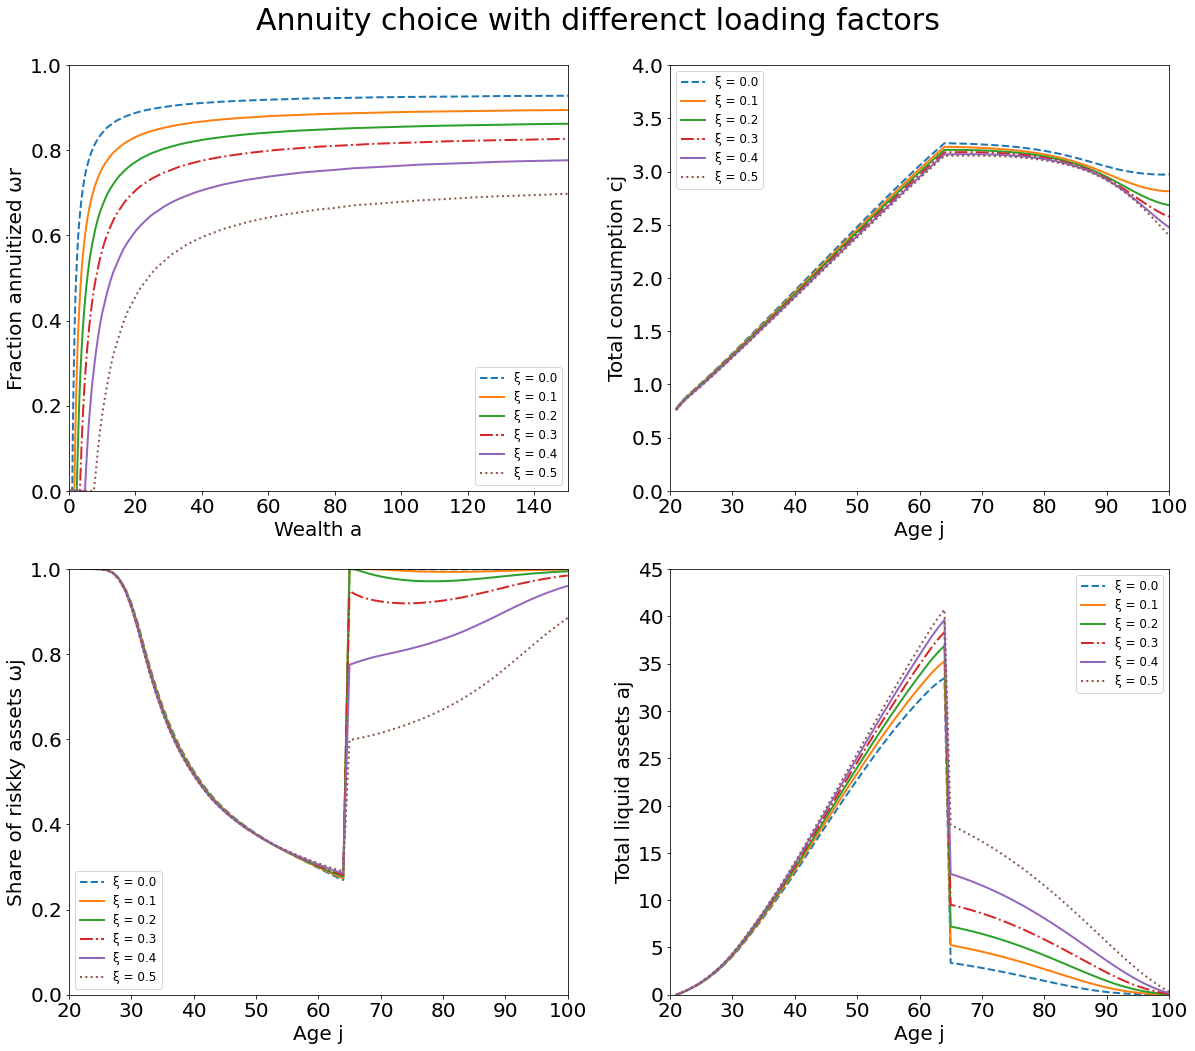

In [41]:
plt.rcParams['lines.linewidth'] = '2'
plt.rcParams.update({'font.size': 20})
ages = np.arange(model1.J) + 21

fig, ax = plt.subplots(2,2,figsize = (17,15))
fig.suptitle('Annuity choice with differenct loading factors', fontsize = 30)

model = [model1, model2, model3, model4, model5, model6]
lab = ['ξ = {:2.1f}'.format(i) for i in np.arange(6)*0.1]
linstyle = ['--', '-','-', '-.', '-', ':']

for i in range(6):
    ax[0,0].plot(model[i].a, model[i].Ωr, label = lab[i], linestyle = linstyle[i])
ax[0,0].set_xlabel('Wealth a')
ax[0,0].set_ylabel('Fraction annuitized ωr')
ax[0,0].set_xlim(0,150)

for i in range(6):
    ax[0,1].plot(ages, model[i].c_coh, label = lab[i], linestyle = linstyle[i])
ax[0,1].set_ylabel('Total consumption cj')
ax[0,1].set_ylim(0,4)


for i in range(6):
    ax[1,0].plot(ages[1:], model[i].o_coh[1:], label = lab[i], linestyle = linstyle[i])
ax[1,0].set_ylabel('Share of riskky assets ωj')

for i in range(6):
    ax[1,1].plot(ages, model[i].a_coh, label = lab[i], linestyle = linstyle[i])
ax[1,1].set_ylabel('Total liquid assets aj')
ax[1,1].set_ylim(0,45)

for i in range(2):
    for j in range(2):
        if not (i == 0 and j == 0):
            ax[i,j].set_xlabel('Age j')
            ax[i,j].set_xlim(20,100)
        if j == 0:
            ax[i,j].set_ylim(0,1)
        ax[i,j].legend(fontsize = 12)

fig.tight_layout() 